# Site Data Temperature Compensation

* Processing and manipulation of site data for the Argus project.
* The aim is to process sensor data that has a corresponding temperature sensor.
* Rework and using previous notebooks.

In [122]:
import numpy as np
import pandas as pd
import src.dataIO as io
import src.filepaths as fp
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

root = Path().absolute()
storage = Path('K://Josh/Argus_Project')

site_data = Path(f'{storage}/Site_Data/Sensor_Data')
out_path = Path(f'{storage}/Site_Data/Sensor_Figures')

* Read in all the files in the site data directory as the sensors are individually tagged and have a time date stamp, so the order of the files and file names are irrelevant here.
* Uses a standard function intended to find all files with a given file type.

In [123]:
data_files = fp.extractfile(
    directory_path=site_data,
    file_string='.csv')
print(data_files)

['AmineOxide_Data_240717.csv', 'FFR_Data_240618.csv', 'FFR_Data_240702.csv', 'FFR_Data_240708.csv', 'FFR_Data_240715.csv', 'FFR_Data_240729.csv', 'Hoyer_Data_240708.csv', 'Hoyer_Data_240715.csv', 'Hoyer_Data_240729.csv', 'L300_Data_240625.csv', 'L300_Data_240702.csv', 'L300_Data_240715.csv', 'L300_Data_240723.csv', 'L300_Data_240729.csv', 'Libra_Data1_240625.csv', 'Libra_Data2_240625.csv', 'Libra_Data_240618.csv', 'Libra_Data_240715.csv', 'Libra_Data_240724.csv', 'Libra_Data_240729.csv']


* Read the headers to track individual sensors.
* Note that this only works if the sensor tags are kept consistent at the plant/sensor location/server.
* Headings/tags are used to track the sensors along with the time stamp information.

In [124]:
headers = []
for file in data_files:
    file_path = Path(f'{site_data}/{file}')
    data = pd.read_csv(
        filepath_or_buffer=file_path,
        sep=',')
    data_headers = list(data)
    for header in data_headers:
        if header == 'timestamp':
            pass
        elif header not in headers:
            headers.append(header)
        else:
            pass
print(headers)

['Amine_Oxide_Flow_Sensor_1', 'Amine_Oxide_Flow_Sensor_2', 'MgS04_RM_LHS_Sensor_2_value', 'MgS04_RM_LHS_Sensor_3_value', 'MgS04_RM_RHS_Sensor_2_value', 'MgS04_RM_RHS_Sensor_3_value', 'T200_Sensor_2_value', 'T200_Sensor_3_value', 'T52_Sensor_2_value', 'T52_Sensor_3_value', 'Amine_Oxide_Ring_Main_Tank_Temperature_Transmitter', 'Amine_Oxide_T51_Tank_Level', 'Amine_Oxide_T52_Tank_Level', 'MgS04_RM_LHS_Temp_2_value', 'MgS04_RM_LHS_Temp_3_value', 'MgS04_RM_RHS_Temp_2_value', 'MgS04_RM_RHS_Temp_3_value', 'MgSO4_T200_Tank_Level', 'Amine_Oxide_Ring_Main_Process_Variable', 'T200_Temp_2_value', 'T200_Temp_3_value', 'T52_Temp_2_value', 'T52_Temp_3_value', 'Auto_meas_procc_dis', 'Auto_meas_procc_period', 'Auto_measure', 'Controller_error_sts', 'External_Power', 'Sensor_2', 'Sensor_2_raw', 'Sensor_3', 'Sensor_3_raw', 'Sensor_4', 'Sensor_4_raw', 'Sensor_data', 'Temperature_2', 'Temperature_3', 'Temperature_4', 'Temperature_External', 'Charging', 'Firmware_version', 'Status', 'L300_Sensor_1_value', 'L

* Now we need to filter the headers that we want.
* To optimise the temperature compensation, we will start with the Amine Oxide Flow line, for no particular reason other than we know it hasn't had any temperature compensation, and we know it's a flow sensor, so we know that there is plenty of data to go at.
* Filter the desired headers by looking for the tag within headers.

In [125]:
desired_string = 'Amine_Oxide_Flow'
non_desired_string = 'Output'
desired_headers = [
    header
    for header in headers
    if desired_string in header
    and non_desired_string not in header]
print(desired_headers)

['Amine_Oxide_Flow_Sensor_1', 'Amine_Oxide_Flow_Sensor_2', 'Amine_Oxide_Flow_Temp_1', 'Amine_Oxide_Flow_Temp_2']


* Now we have the desired headers we want, we need to concatenate the data into some sort of time order.
* Introduce a function to parse the time stamps from the different server outputs.
* Some are in a different format, which is helpful but not an issue with this function.
* Add the timestamp formats to the top if statement if further issues arise.
* Function exists in src.dataIO.
* Set time 0 to be the start of the data transfer period.
* First batch of data began at 6am on the 11th of June 2024.

In [126]:
t_0 = '11/06/2024 06:00'
t_0_object = io.parse_date(date_string=t_0)
t0 = io.convert_datetime(date_time=t_0_object)
print(t0)

1718082000.0


* Sort data into time, sensor, sensor, temp, temp etc.
* Data is not guaranteed to be in order.
* Zero timestamp data to t0.
* NOTE:
  * The section below was modified to exclude doubled-timestamp data.
  * It's likely that what happens is people send me doubled-up data and that confuses the system because it's not always the same for the temperature and sensor data.
  * That means that the two arrays end up different lengths and then can't be plotted against each other.
  * Origin can deal with that, but Python can't.
  * Python can't deal with empty segments of an array.
  * The following code has been adjusted to loop individually through the timestamp and header arrays.
  * This does increase processing time, slightly, but it does fix the problem in a very simple way.

In [127]:
data = {}
for header in desired_headers:
    time_data = []
    sensor_data = []
    for file in data_files:
        file_path = Path(f'{site_data}/{file}')
        csv_data = pd.read_csv(
            filepath_or_buffer=file_path,
            sep=',')
        data_headers = list(csv_data)
        if header in data_headers:
            time_array = csv_data['timestamp']
            header_array = csv_data[f'{header}']
            for t, h in zip(time_array, header_array):
                if t in time_data:
                    pass
                else:
                    time_data.append(t)
                    sensor_data.append(h)
    time_objects = [io.parse_date(date_string=string) for string in time_data]
    time = [io.convert_datetime(date_time=time) for time in time_objects]
    zipped_lists = zip(time, sensor_data)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    sorted_time, sorted_sensor = [list(tuple) for tuple in tuples]
    time_seconds = [io.zeros_times(time=t, t_0=t0) for t in sorted_time]
    data.update({f'{header}': [time_seconds, sorted_sensor]})
for header, values in data.items():
    print(header, values)

Amine_Oxide_Flow_Sensor_1 [[0.0, 300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0, 2100.0, 2400.0, 2700.0, 3000.0, 3300.0, 3600.0, 3900.0, 4200.0, 4500.0, 4800.0, 5100.0, 5400.0, 5700.0, 6000.0, 6300.0, 6600.0, 6900.0, 7200.0, 7500.0, 7800.0, 8100.0, 8400.0, 8700.0, 9000.0, 9300.0, 9600.0, 9840.0, 9900.0, 10200.0, 10500.0, 10800.0, 11100.0, 11400.0, 11640.0, 11700.0, 12000.0, 12300.0, 12600.0, 12900.0, 13200.0, 13500.0, 13800.0, 14100.0, 14400.0, 14700.0, 15000.0, 15300.0, 15600.0, 15900.0, 16200.0, 16440.0, 16500.0, 16800.0, 17100.0, 17400.0, 17640.0, 17700.0, 18000.0, 18300.0, 18600.0, 18900.0, 19200.0, 19500.0, 19800.0, 20100.0, 20400.0, 20700.0, 21000.0, 21300.0, 21600.0, 21840.0, 21900.0, 22200.0, 22500.0, 22800.0, 23100.0, 23340.0, 23400.0, 23700.0, 24000.0, 24300.0, 24600.0, 24900.0, 25200.0, 25500.0, 25800.0, 26100.0, 26400.0, 26700.0, 27000.0, 27300.0, 27600.0, 27900.0, 28200.0, 28500.0, 28800.0, 29100.0, 29400.0, 29700.0, 30000.0, 30240.0, 30300.0, 30600.0, 30900.0, 31140.0, 31200

* Ok, so now we have all the sensor headers, and their sorted time/data values in seconds.
* Now we need to find a way to split the array based on the cycle.
* To do this, we might need to use ginput, which might not work in Jupyter notebooks.
* Let's give it a go.

In [128]:
"""
for header, values in data.items():
    x_coords = []
    if 'Temp' in header:
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=[15, 9])
        ax.plot(values[0], values[1], marker='o', ms=2)
        ax.set_title('Select Points (Press Enter To Finish)')
        while True:
            points = plt.ginput(n=1, timeout=0)
            if not points:
                break
            x_coords.append(points[0][0])
        plt.close()
    else:
        pass
    print(x_coords)
"""

"\nfor header, values in data.items():\n    x_coords = []\n    if 'Temp' in header:\n        fig, ax = plt.subplots(\n            nrows=1,\n            ncols=1,\n            figsize=[15, 9])\n        ax.plot(values[0], values[1], marker='o', ms=2)\n        ax.set_title('Select Points (Press Enter To Finish)')\n        while True:\n            points = plt.ginput(n=1, timeout=0)\n            if not points:\n                break\n            x_coords.append(points[0][0])\n        plt.close()\n    else:\n        pass\n    print(x_coords)\n"

In [129]:
x_coordinates = {
    'Temp1': [624985.5522580645, 719158.0425806451, 808621.9083870967, 893377.1496774193, 980486.7032258065, 1065241.9445161289, 2364822.3109677415, 2454286.176774193, 2529624.1690322575, 2626150.971612903, 2699134.651612903, 2793307.1419354836, 2885125.3199999994, 2960463.3122580643, 3047572.865806451, 3132328.1070967736, 3403074.016774193, 3485474.945806451, 3572584.4993548384, 3664402.677419354],
    'Temp2': [529764.6572580645, 614640.9862231183, 633806.6088926465, 667346.448564321, 695410.3960447017, 706362.1804272893, 720736.3974294355, 740586.5066228755, 771388.400198903, 787131.5902488728, 803559.266822754, 817248.9973009885, 839152.5660661637, 872692.4057378382, 919237.4893638354, 957568.734702892, 1013012.1431397416, 1042445.0636679458, 1062979.6593852974, 1099941.9316765307, 1154016.3670655568, 2313891.915322581, 2338144.0608740896, 2361048.86500607, 2418984.546045786, 2491067.3119905484, 2563150.0779353105, 2680368.78143427, 2743693.8281520987, 2822513.3011945025, 2928279.6026274716, 3002383.380701526, 3074466.1466462887, 3126338.7912981273, 3330108.72983871, 3380399.1753923874, 3426233.5055172574, 3473977.59939733, 3535408.333523024, 3605114.7105879304, 3705059.0137768826]
}

* Above are the coordinates I set using the commented-function to find the x-coordinates for the temperature sensors for the Amine Oxide Flow line.
* It's not perfect, but at a rough guess it works quite well.
* Now we need to split the arrays based on that data.

In [130]:
trimmed_data = {}
for header, values in data.items():
    x_values = np.array(values[0])
    if 'Sensor_1' or 'Temp_1' in header:
        indices = [np.argmin(np.abs(x_values - x)) for x in x_coordinates['Temp1']]
    else:
        indices = [np.argmin(np.abs(x_values - x)) for x in x_coordinates['Temp2']]
    if len(indices) %2 != 0:
        raise ValueError('Indices list length is not even')
    segments = []
    for i in range(0, len(indices), 2):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        segment_x = values[0][start_idx: end_idx + 1]
        print(len(segment_x))
        segment_y = values[1][start_idx: end_idx + 1]
        print(len(segment_y))
        segments.append({'x': segment_x, 'y': segment_y})
    trimmed_data.update({f'{header}': segments})
for key, segments in trimmed_data.items():
    print(f"{key}:")
    for i, segment in enumerate(segments):
        print(f"  Segment {i + 1}:")
        print(f"    x: {segment['x']}")
        print(f"    y: {segment['y']}")

415
415
353
353
360
360
372
372
397
397
385
385
557
557
1206
1206
1162
1162
1294
1294
415
415
353
353
360
360
372
372
397
397
385
385
557
557
1206
1206
1162
1162
1294
1294
315
315
284
284
284
284
372
372
397
397
385
385
557
557
1206
1206
1162
1162
1294
1294
315
315
284
284
284
284
372
372
397
397
385
385
557
557
1206
1206
1162
1162
1294
1294
Amine_Oxide_Flow_Sensor_1:
  Segment 1:
    x: [624900.0, 625200.0, 625500.0, 625560.0, 625800.0, 626100.0, 626160.0, 626400.0, 626700.0, 626760.0, 627000.0, 627300.0, 627600.0, 627900.0, 628200.0, 628500.0, 628800.0, 629100.0, 629160.0, 629400.0, 629700.0, 629760.0, 630000.0, 630300.0, 630600.0, 630900.0, 631200.0, 631500.0, 631800.0, 632100.0, 632400.0, 632700.0, 632760.0, 633000.0, 633300.0, 633600.0, 633900.0, 634200.0, 634440.0, 634500.0, 634800.0, 635100.0, 635400.0, 635700.0, 636000.0, 636300.0, 636540.0, 636600.0, 636660.0, 636900.0, 637200.0, 637500.0, 637740.0, 637800.0, 638100.0, 638400.0, 638460.0, 638700.0, 639000.0, 639300.0, 639600.0

* OK that works.
* Now we need to plot the x and y segments against each other and find the relationship between the two.
* This is the temperature correlation algorithm that I discussed in my OneNote documents.

In [131]:
sensor_headers = []
temperature_headers = []
for header, segments in trimmed_data.items():
    if 'Temp' in header:
        temperature_headers.append(header)
    else:
        sensor_headers.append(header)
print(sensor_headers, temperature_headers)

['Amine_Oxide_Flow_Sensor_1', 'Amine_Oxide_Flow_Sensor_2'] ['Amine_Oxide_Flow_Temp_1', 'Amine_Oxide_Flow_Temp_2']


* The problem below is that there are two arrays that are different lengths here. SO when they are sliced above, they do not come out at the same length.
* That's annoying.
* Apparently, that's not the case. I changed the print statement above and they came through just fine, both the same length of data. Which makes sense as they are sampling at the same rate.
* So what else is going on.

In [132]:
for key, segments in trimmed_data.items():
    print(f"{key}:")
    for i, segment in enumerate(segments):
        print(f"  Segment {i + 1}:")
        print(f"    x: {segment['x']}")
        print(f"    y: {segment['y']}")
        print(f"  Length {i + 1}:")
        print(f"    x: {len(segment['x'])}")
        print(f"    y: {len(segment['y'])}")

Amine_Oxide_Flow_Sensor_1:
  Segment 1:
    x: [624900.0, 625200.0, 625500.0, 625560.0, 625800.0, 626100.0, 626160.0, 626400.0, 626700.0, 626760.0, 627000.0, 627300.0, 627600.0, 627900.0, 628200.0, 628500.0, 628800.0, 629100.0, 629160.0, 629400.0, 629700.0, 629760.0, 630000.0, 630300.0, 630600.0, 630900.0, 631200.0, 631500.0, 631800.0, 632100.0, 632400.0, 632700.0, 632760.0, 633000.0, 633300.0, 633600.0, 633900.0, 634200.0, 634440.0, 634500.0, 634800.0, 635100.0, 635400.0, 635700.0, 636000.0, 636300.0, 636540.0, 636600.0, 636660.0, 636900.0, 637200.0, 637500.0, 637740.0, 637800.0, 638100.0, 638400.0, 638460.0, 638700.0, 639000.0, 639300.0, 639600.0, 639900.0, 640200.0, 640500.0, 640800.0, 641100.0, 641400.0, 641700.0, 642000.0, 642060.0, 642300.0, 642360.0, 642540.0, 642600.0, 642660.0, 642900.0, 643200.0, 643500.0, 643800.0, 644100.0, 644400.0, 644700.0, 644760.0, 645000.0, 645300.0, 645600.0, 645900.0, 646200.0, 646500.0, 646740.0, 646800.0, 646860.0, 647100.0, 647400.0, 647460.0, 64

* Ah, the problem is that the temperature data is not the same length as the sensor data.
* Not that the time and sensor/temp data are not the same length.
* There's a problem with the scaling factor.
* Is it because we have multiple time stamps for the same value on the sensor data?
* Still need to fix this.

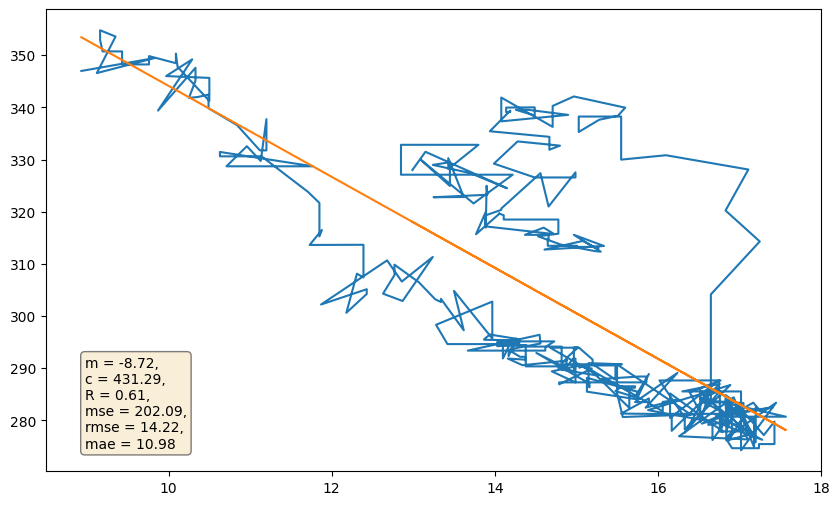

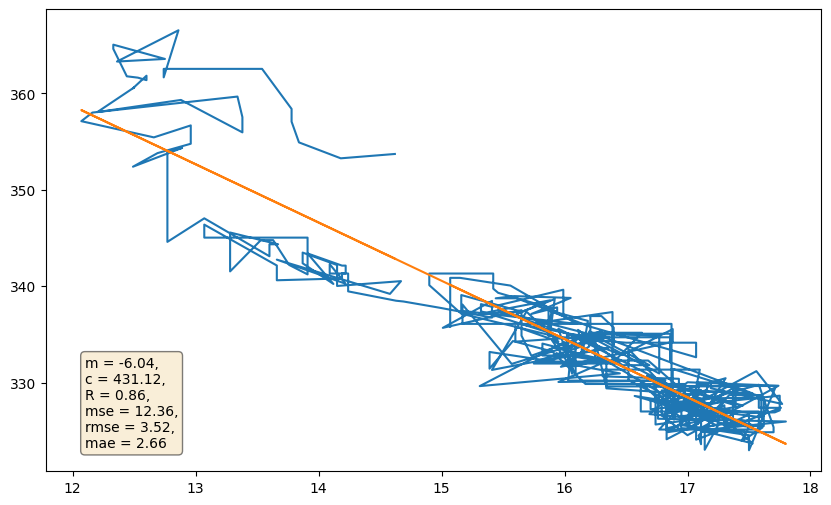

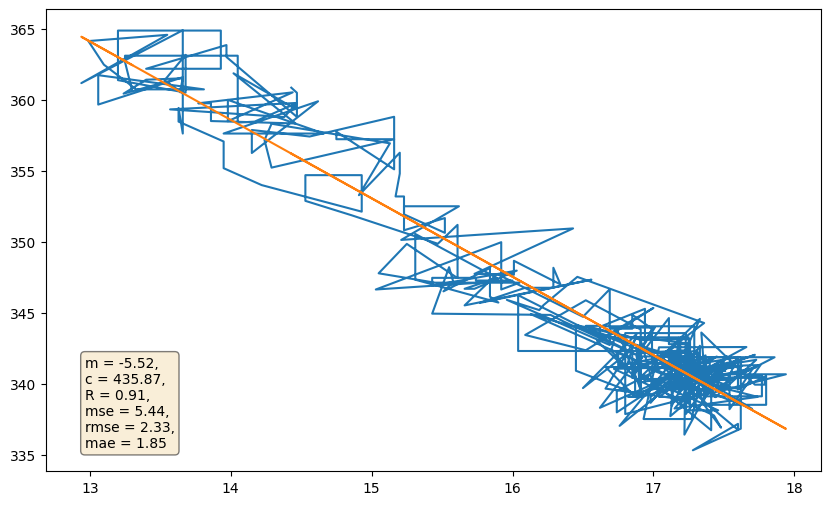

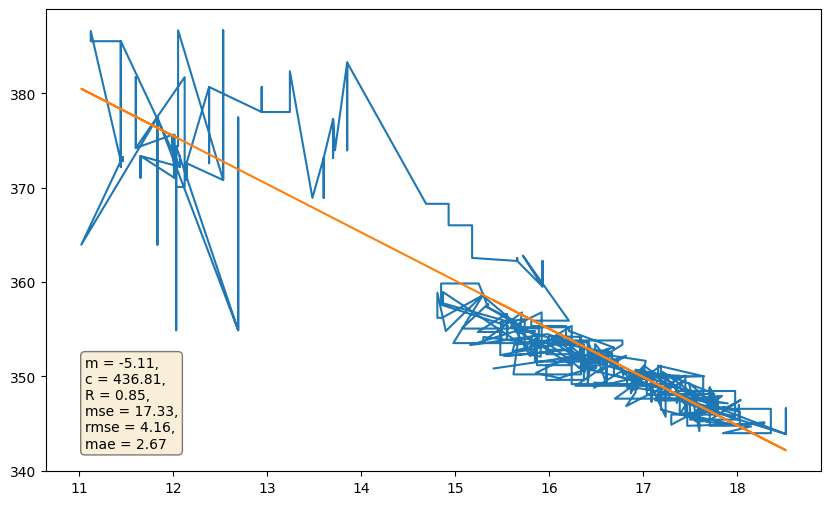

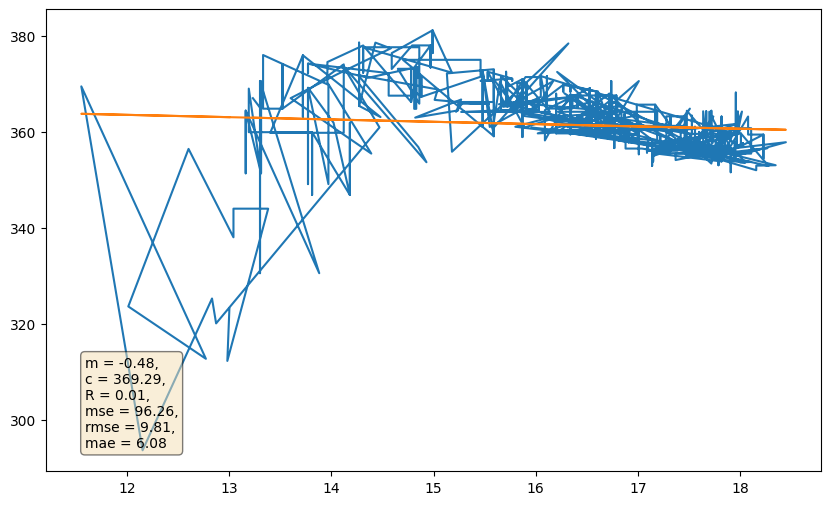

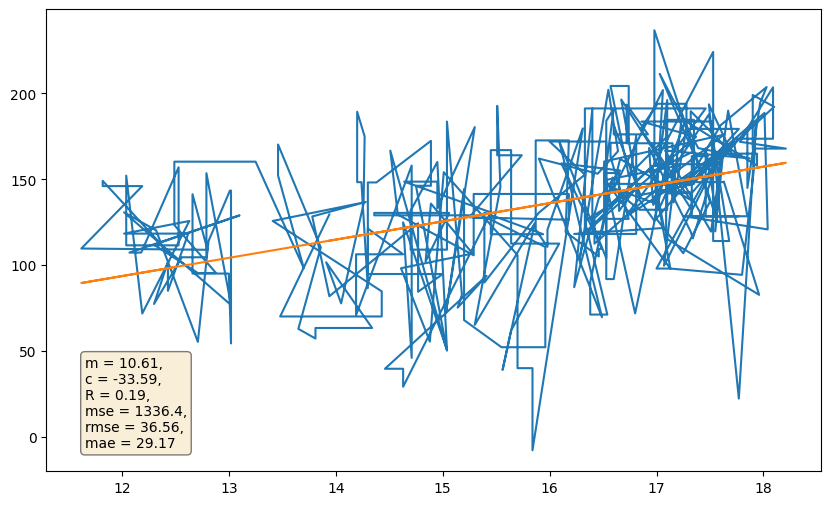

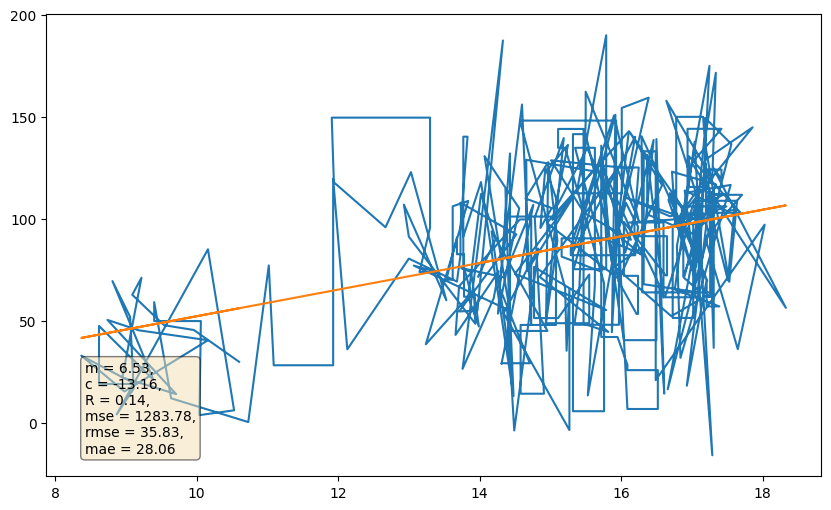

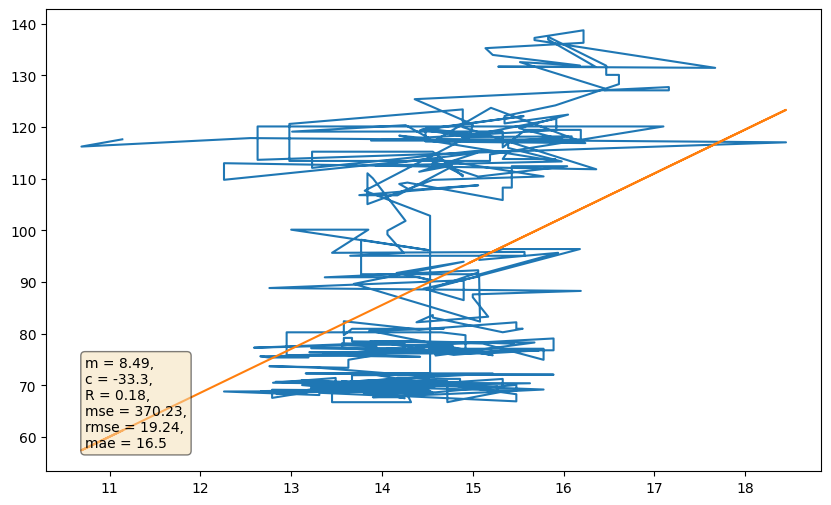

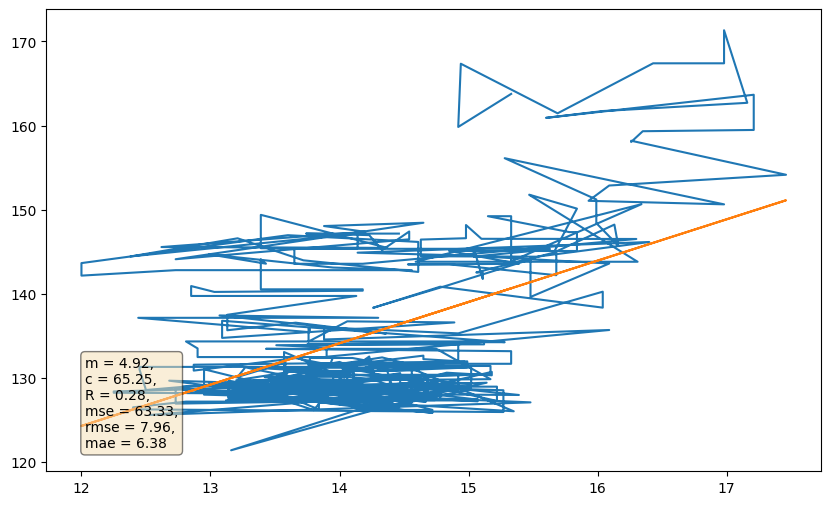

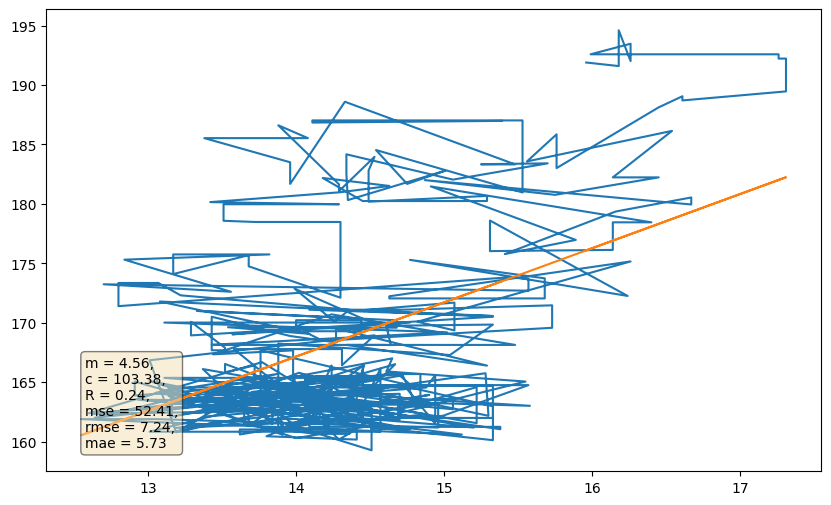

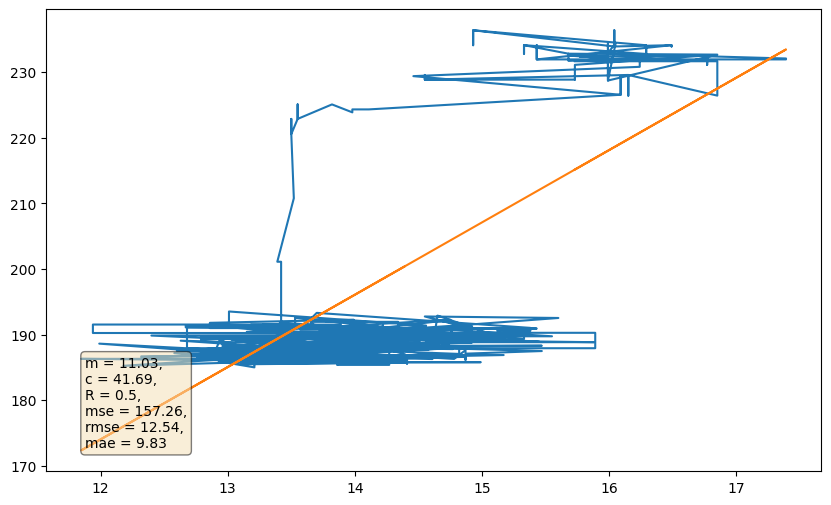

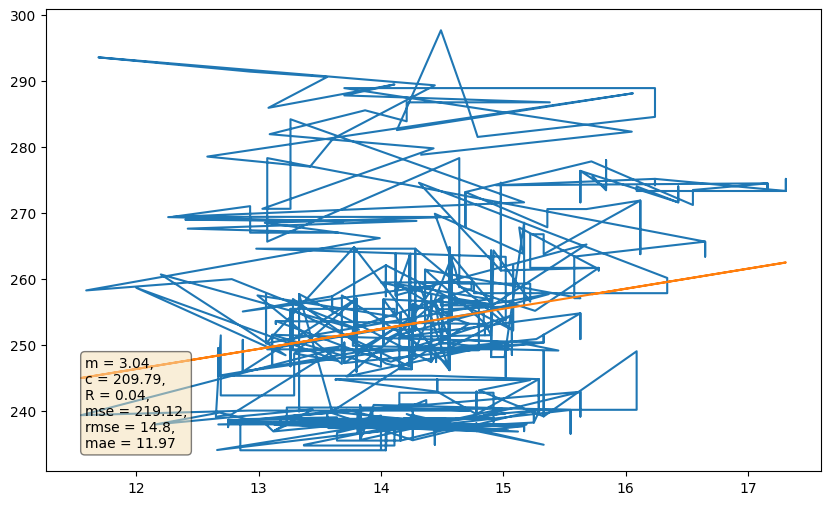

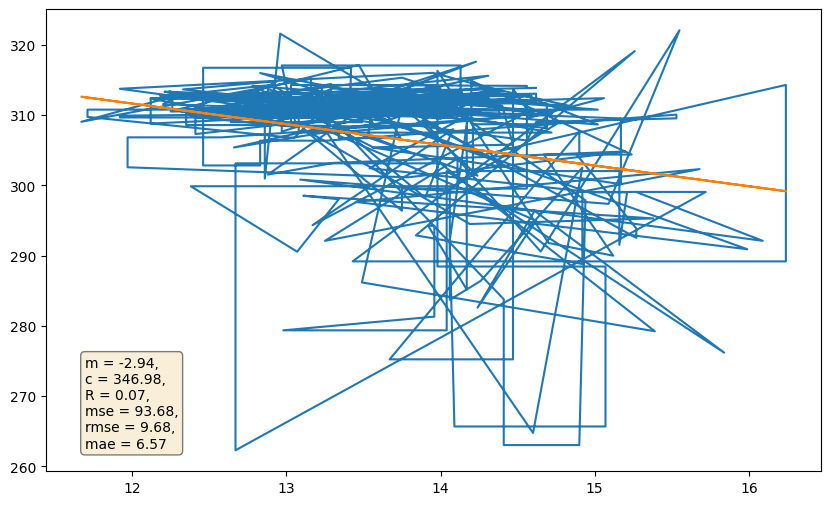

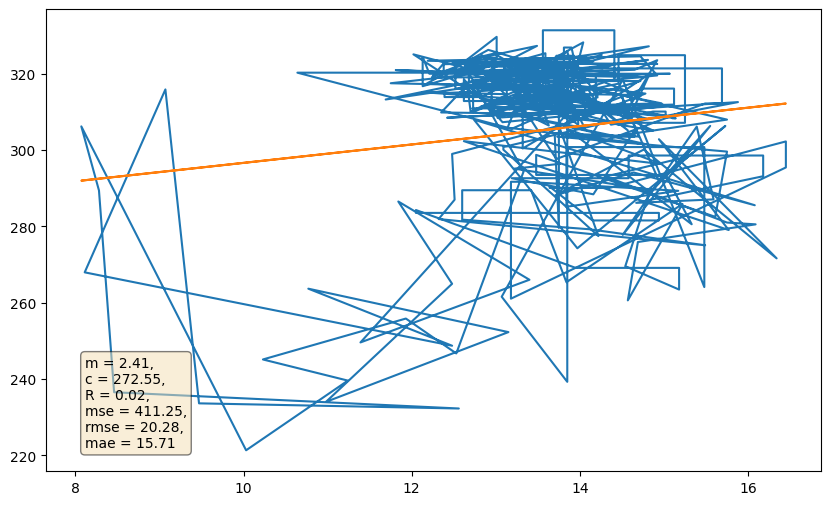

{'Amine_Oxide_Flow_Temp_1': array([ -5.55632859, 434.60278221]), 'Amine_Oxide_Flow_Temp_2': []}


In [133]:
polynomial_degree = 1

average_polynomial = {}

for sensor, temperature in zip(sensor_headers, temperature_headers):
    sensor_segments = trimmed_data[f'{sensor}']
    temperature_segments = trimmed_data[f'{temperature}']
    poly_params = []
    for sense, temp in zip(sensor_segments, temperature_segments):
        x_data = temp['y']
        y_data = sense['y']
        if len(x_data) == len(y_data):
            coefficients = np.polyfit(x_data, y_data, polynomial_degree)
            if polynomial_degree == 1:
                polynomial = np.poly1d(coefficients)
            fit = polynomial(x_data)
            mean = np.mean(y_data)
            tss = np.sum((y_data - mean) ** 2)
            rss = np.sum((y_data - fit) ** 2)
            r_squared = 1 - (rss / tss)
            residuals = y_data - fit
            mse = np.mean(residuals ** 2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(residuals))
            if r_squared > 0.8:
                if polynomial_degree == 1:
                    poly_params.append(coefficients)
            fig, ax = plt.subplots(
                nrows=1,
                ncols=1,
                figsize=[10, 6])
            ax.plot(
                x_data,
                y_data)
            ax.plot(
                x_data,
                fit)
            props = dict(
                boxstyle='round',
                facecolor='wheat',
                alpha=0.5)
            ax.text(
                0.05,
                0.25,
                f'm = {round(coefficients[0], 2)},'
                f'\nc = {round(coefficients[1], 2)},'
                f'\nR = {round(r_squared, 2)},'
                f'\nmse = {round(mse, 2)},'
                f'\nrmse = {round(rmse, 2)},'
                f'\nmae = {round(mae, 2)}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=props)
            plt.show()
    average_coefficients = []
    if len(poly_params) > 0:
        poly_array = np.array(poly_params)
        if polynomial_degree == 1:
            average_coefficients = np.mean(poly_array, axis=0)
    average_polynomial.update({f'{temperature}': average_coefficients})
print(average_polynomial)

* Now that we have the average polynomial for the temperature data, we need to apply the fit to the temperature data so that we can scale up the temperature data.
* Once we do this we can subtract the corrected temperature data from the sensor data to reduce the effect of temperature fluctuations in the sensor data.

In [134]:
scaled_data = {}
for key, values in data.items():
    if key in average_polynomial.keys():
        average_fit = average_polynomial[key]
        if len(average_fit) > 0:
            if polynomial_degree == 1:
                scaled = [(x * average_fit[0]) + average_fit[1] for x in values[1]]
                scaled_data.update({f'{key}': [values[0], scaled]})

sensor_keys = [key for key in data.keys() if 'Sensor' in key]
temp_keys = [key for key in data.keys() if 'Temp' in key]
matches = {}
for sensor_key in sensor_keys:
    prefix = ('_').join(sensor_key.split('_')[0: -2])
    suffix = sensor_key.split('_')[-1]
    temp_key = f'{prefix}_Temp_{suffix}'
    if temp_key in temp_keys:
        matches[sensor_key] = temp_key

corrected_data = {}
for sensor_key, temperature_key in matches.items():
    if temperature_key in scaled_data.keys():
        original_x = data[sensor_key][0]
        original_y = data[sensor_key][1]
        scaled_x = scaled_data[temperature_key][0]
        scaled_y = scaled_data[temperature_key][1]
        scaled_dict = dict(zip(scaled_x, scaled_y))
        corrected_x = original_x
        corrected_y = np.zeros_like(original_y)
        for i, xi in enumerate(original_x):
            if xi in scaled_dict:
                corrected_y[i] = original_y[i] - scaled_dict[xi]
            else:
                corrected_y[i] = original_y[i]
        corrected_data.update({f'{sensor_key}': [corrected_x, corrected_y]})

* Now plot the temperature corrected data.

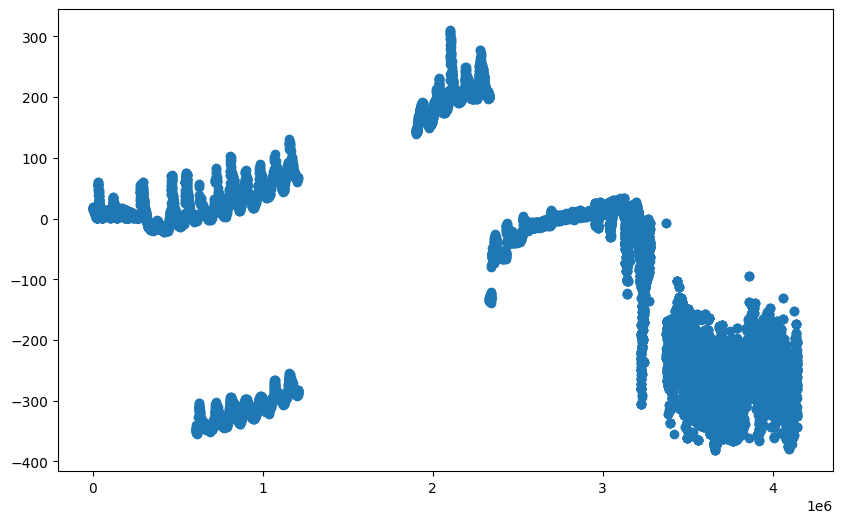

In [135]:
for sensor, data in corrected_data.items():
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=[10, 6])
    ax.scatter(
        data[0],
        data[1])
    plt.show()